## MNIST 

MNIST stuff.

## Get Data

from Azure? 

In [1]:
from adlfs import AzureBlobFileSystem


container_name = "datasets"
storage_options = {"account_name": "azuremlexamples"}

In [2]:
fs = AzureBlobFileSystem(**storage_options)
fs

In [3]:
files = fs.ls(f"{container_name}/mnist")
files

['datasets/mnist/t10k-images-idx3-ubyte.gz',
 'datasets/mnist/t10k-labels-idx1-ubyte.gz',
 'datasets/mnist/train-images-idx3-ubyte.gz',
 'datasets/mnist/train-labels-idx1-ubyte.gz']

In [4]:
filename = "train-images-idx3-ubyte.gz"

f = fs.open(f"{container_name}/mnist/{filename}")
f

In [5]:
import gzip
import numpy as np

f = gzip.open(f, "r")
f

<gzip adlfs.spec.AzureBlobFile object at 0x7fb6b8600e50 0x7fb6a850a790>

In [6]:
image_size = 28
num_images = 5

import numpy as np
f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

## EDA

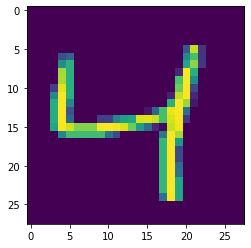

In [7]:
import matplotlib.pyplot as plt
image = np.asarray(data[2]).squeeze()
plt.imshow(image)
plt.show()